## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project we will be working to understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
# Read ab_data.csv dataset
df = pd.read_csv("ab_data.csv")
df.tail()

,user_id,timestamp,group,landing_page,converted
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


In [3]:
# number of rows in the dataset
df.shape[0]

294478

In [4]:
# number of unique users 
df['user_id'].nunique()

290584

In [5]:
# proportion of users converted.
users_converted = df.query('converted==1')['user_id'].nunique()/df['user_id'].nunique()
users_converted

0.12104245244060237

In [6]:
#times the new_page and treatment don't line up.
df.query('group=="treatment" and landing_page != "new_page"').shape[0] + df.query('group!="treatment" and landing_page=="new_page"').shape[0]

3893

In [7]:
# Do any rows have missing values?
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

In [8]:
# Deleting rows were treatment is not aligned with new_page or control is not aligned with old_page.
df2 = df.drop(df.query('group=="treatment"').query("landing_page!='new_page'").index)
df2 = df2.drop(df.query('group!="treatment"').query("landing_page=='new_page'").index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
# How many unique **user_id**s are in **df2**?
df2.user_id.nunique()

290584

In [11]:
# Find duplicateds
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
# Remove duplicated
df2 = df2.drop(1899)

# check if there aren't any duplicated rows.
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


What is the probability of an individual converting regardless of the page they receive?

In [13]:
# converted probability
converted_prob = df2.query('converted==1').shape[0]/df2.shape[0]
converted_prob

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
# control converted probability
control = df2.query('group=="control"')
control_converted_prob = control.query('converted==1').shape[0]/control.shape[0]
control_converted_prob

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
# treatment converted probability
treatment = df2.query('group=="treatment"')
treatment_converted_prob = treatment.query('converted==1').shape[0]/treatment.shape[0]
treatment_converted_prob

0.11880806551510564

In [16]:
diff_treatmen_control = treatment_converted_prob - control_converted_prob
diff_treatmen_control

-0.0015782389853555567

What is the probability that an individual received the new page?

In [17]:
df2.query('group=="treatment"').shape[0]/df2.shape[0]

0.5000619442226688

**From what we found above, the difference between people who converted in both groups is very small (-0.0015), which could suggest that the Null hypothesis (there were the same or fewer conversions in the treatment with respect to the control) has not been rejected .**

<a id='ab_test'></a>
### Part II - A/B Test

I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, so my hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages, are:

$$H_0: p_{new} - p_{old} <= 0$$

$$H_1: p_{new} - p_{old} > 0$$

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
# convert rate for p_new under the null
p_new = df.converted.mean()
p_new

0.11965919355605512

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
# convert rate for p_old under the null
p_old = df.converted.mean()
p_old

0.11965919355605512

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
# number of individuals in the treatment group
n_new = df2.query('group=="treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
# number of individuals in the control group
n_old = df2.query('group=="control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# To simulate 𝑛_𝑛𝑒𝑤 transactions with a convert rate of 𝑝_𝑛𝑒𝑤 under the null, we can use
# np.random.binomial(1, p_new, n_new)
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# np.random.binomial again to simulate 𝑛_old transactions with a convert rate of 𝑝_old under the null
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 0, 0, ..., 1, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [24]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0012299417863626955

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
# Simulate thousands p_new and p_old values 
thousands_new = np.random.binomial(n_new, p_new, 10000) / n_new
thousands_old = np.random.binomial(n_old, p_old, 10000) / n_old
p_diffs = thousands_new - thousands_old

i. Plot a histogram of the **p_diffs**. 

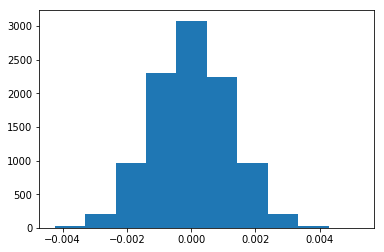

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
(diff_treatmen_control < p_diffs).mean()

0.9057

**This number (0.9133) is the P-value. This value indicate us the probability of an event happening under the null. In this case, having a P-value so high indicate us that the difference that we found between treatment and control has a 90% probability of happening under the null by chance. With this P-value so high (way higher than an alpha of 0.05) we can't find evidence to reject the null.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
# Import statsmodels module
import statsmodels.api as sm

# get info
convert_old = df2.query('group=="control" and converted==1').shape[0]
convert_new = df2.query('group=="treatment" and converted==1').shape[0]
n_old =  df2.query('group=="control"').shape[0]
n_new = df2.query('group=="treatment"').shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [29]:
# Find zstat and p_value using statsmodels
zstat, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

zstat, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The Z stat is the z score, which is the number of standard deviation an observation is away from the mean of a sampling distribution. A z score of -1.31 tells us that the difference between conversion rates of the old and new pages is only -1.31 times away from the mean of a sampling distribution simulating the null hypothesis. This number (z score = |1.31|) is too low to think that an observation like we found doesn't come by chance under the null.**

**We already know what the P value means. Here, we can find that the p value found with statsmodels is basically the same that we found simulating the null.**

**Having a z score as low as |1.31 and a p value as high as 0.905 is in line with what we found before: there's no evidence to reject the null.**

<a id='regression'></a>
### Part III - A regression approach

`1.` Now, will see that the result acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Given that we are going to analyze binary categorical values, we should perform Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
# First, we need to create an intercept column.
df2['intercept'] = 1

# And create a dummy variable column for the categorical values
df2[['_', 'ab_page']] = pd.get_dummies(df2["group"])

# I'll drop one of the columns, as we won't use it when performing the regression model.
df2 = df2.drop("_", axis=1)

In [31]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import the regression model. Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [32]:
# Logistic Regression!
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of the model below, and use it as necessary to answer the following questions.

In [33]:
# Show the summary of the result
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 30 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        12:29:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

**The p-value associated with ab_page is 0.190, that, again, is higher than an alpha of 0.05, which indicate us that ab_page isn't statistically significant. This p-value is different from what we found before because the null and alternative hypothesis for the null simulation and the logistic regression are different. In the simulation we did before, the null hypothesis was that $p_{new} - p_{old} <=0$ and in this regression, the null hypothesis is that there is no relationship between treatment and control group to the probability of conversion.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**I'm wondering if the AB Test was run for enough time.**

In [34]:
# First, let's see how much time the test was run.
df2.timestamp.min(), df2.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

In [35]:
# Now, let's run a sm.stats.proportions_ztest but for dates equal or bigger than 2017-01-18, one week before 
# the last unique user in the AB test.

df3 = df2[df2['timestamp'] >= '2017-01-18']

convert_old_df3 = df3.query('group=="control" and converted==1').shape[0]
convert_new_df3 = df3.query('group=="treatment" and converted==1').shape[0]
n_old_df3 =  df3.query('group=="control"').shape[0]
n_new_df3 = df3.query('group=="treatment"').shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [36]:
zstat_df3, p_value_df3 = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

zstat_df3, p_value_df3

(-1.3109241984234394, 0.9050583127590245)

**Although the p-value dropped to 0.64, it is still too large to reject the null. It seems that date is not a revelant factor.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
# Read countries.csv and merge it with df2
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [38]:
# Create a dummy variable column for the categorical values
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [39]:
# Fit Linear Model And Obtain the Results
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 30 Jun 2019   Pseudo R-squ.:               1.521e-05
Time:                        12:29:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
# Fit Linear Model And Obtain the Results
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        12:29:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Here we can see again p-values higher than an alpha of 0.05, indicating us that these values are not statistically significant to predict the conversion.**

<a id='conclusions'></a>
## Conclusions

After running several tests, we could not find any evidence to support that the new page is more effective in achieving conversions than the old page.

In the same way, when adding country variables to our analysis, we could not find that these are statistically significant for the conversion result.

Based on what we found in the tests we run, we wouldn't recommend to the company to use the new page, as we couldn't find any evidence that suggest tha this new page is better than the old page at converting users.